# Contextual bandits

Imagine the following scenarios:

  * you have a tDCS stimulator that has a series of knobs - frequency, amplitude, location of electrodes, etc. - and you want to find a stimulation protocol that "just works" and improves people's performance on a psychophysical task.
  * you're about to run a drug trial for a really rare, deadly disease - so deadly that it would be unethical to keep people in the placebo arm when you know they would be better in the treatment arm. But it doesn't work for everybody, and the factors that make it work on not aren't fully known. You want to direct the right people to the treatment arm as you're learning about which factors cause the drug to work or not.
  * More prosaically, you're on Tinder and you want to optimize your photo selection, your profile text, etc. so you can most efficiently find love. Time's a wasting!
  
Each of these scenarios has characteristics of a regression problem - learning the underlying factors that cause a measurement. But they also have characteristics of an exploration/exploitation problem - balancing learning about a system and exploiting your current knowledge to maximize your expected long-term outcome.

<p style="text-align: center"><a href="https://en.wikipedia.org/wiki/File:Las_Vegas_slot_machines.jpg#/media/File:Las_Vegas_slot_machines.jpg"><img src="https://upload.wikimedia.org/wikipedia/en/8/82/Las_Vegas_slot_machines.jpg" alt="Las Vegas slot machines.jpg" height="447" width="640"></a><br><a href="http://creativecommons.org/licenses/by-sa/3.0/" title="Attribution-ShareAlike 3.0">CC BY-SA 3.0</a>, https://en.wikipedia.org/w/index.php?curid=5709790</p>

Multi-armed bandits are a formalization of the exploration / exploitation problem. Imagine you have a series of one-armed bandits - slot machines - that give you a stochastic reward when you pull them. You have some number of trials to maximize your total reward. You can think of all kinds of heuristics for solving this - pull an arm until it doesn't give you a reward, then switch, etc. 

In fact, the optimal solution to this problem is, by and large, intractable - you can find an optimal policy for binary rewards using dynamic programming but it doesn't scale to large state spaces and many actions. People have come up with all sorts of heuristics to solve this problem, which arent't quite optimal, but they work. This includes approaches like epsilon-greedy, Gibbs sampling, UCB, EXP4, etc. See this [excellent post by Ian Osband](http://iosband.github.io/2015/07/19/Efficient-experimentation-and-multi-armed-bandits.html) for a more thorough introduction. 

The best-in-class approaches focus on representing the uncertainty in the reward distributions and decreasing it. The answer, as always, is to be Bayesian. One of the best known solutions is to always pick the arm with the highest upper confidence bound (UCB) at every trial. Another one, which I'm very fond of, is Thompson sampling. You sample from the posterior for you model parameters, and then you act optimally, assuming that these are the true parameters. I'll explain this in more detail later. 

## Bayesian GLMs for the contextual bandit

Combining elements of the multi-armed bandit with regression, as in the problems above, yields the problem class known as contextual bandits. You can use different formulations for the reward distribution - Gaussian processes, Bayesian neural nets - as long as you can sample from the posterior of the model parameters. Here we'll focus on the simplest class - Bayesian GLMs. Let's assume that the mean of the reward on a given trial is given by:

$$\mu = f(\mathbf{x}^T \mathbf{w})$$

And that the actual reward $y$ is taken from a distribution:

$$y = \text{Distribution}(\mu, \zeta)$$

Here $\mathbf{x}$ is the design for the trial, $w$ are the weights corresponding to the factors of interest, $f$ is a nonlinearity, and $\zeta$ are parameters of the noise distribution. 

This generalized linear model (GLM) formulation can accomodate continuous rewards (identity-normal), binary rewards (logistic-binomial), integer rewards (exponential-Poisson), etc. 

## Designing design matrices

Every trial, you learn a little more about $\mathbf{w}$, which helps you pick the design $\mathbf{x}$ for the next trial. In the tDCS example, $\mathbf{x}$ could encode:

  * binary variables: whether user receives real or sham stimulation
  * categorical variables: whether you use a square wave, sinusoid, or random noise stimulation
  * (constrained) continuous variables: the frequency and amplitude of stimulation
  
Some other elements of the design matrix can be set in stone - the age of a subject, for example. We can't change them, but they will influence our optimal action selection, e.g. whether they should be redirected to the experimental arm in the medical trial example.

## Prior information

We need to represent uncertainty to sample from our posterior, and we'll need a proper prior for our weights:

$$\mathbf{w} \sim \text{Normal}(0, \text{precision} = \Lambda)$$

Then we turn the Bayesian crank on this GLM to estimate the model parameters. For the logistic-binomial model, for example, we know how to solve for the MAP value of $\mathbf{w}$, by iterating:

$$\mathbf{w} \leftarrow \mathbf{w} - \mathbf{H}^{-1}\mathbf{g}$$
$$\mathbf{H} = \mathbf{X}^T\text{diag}(\mu(1-\mu))\mathbf{X} + \lambda \mathbf{I}$$
$$\mathbf{g} = \mathbf{X}^T (\mathbf{y} - \mathbf{\mu})$$

Here $\mathbf{X}$ is a collection of all trials (one row per trial).

## Thompson sampling

Every time that we get a new dump of data, we update our estimates of model parameters. But how should we act on this? We ought to select our next trial design so that the expected reward (psychophysical performance, survivals, swipes, etc.) at the end of our trials is maximized. But we can't simply pick the best current experimental parameters and use that for the next trial; then we'll never get any information about other variations!

So we have to balance exploiting (showing what is known to work) and exploring (presenting new things that have a shot of working). One that works really well in practice is Thompson sampling. It's really quite simple - take a sample from the posterior distribution of $\mathbf{\hat{w}} \sim p(\mathbf{w})$. Find the design that maximizes:

$$\mathbf{x}^T \mathbf{\hat{w}}$$

Use that for each trial. So, sampling and a really simple maximization. What's nice about it, apart from the fact that it works really well in practice and it's dead simple to implement, is that it's a stochastic policy, and that means it's robust to delayed updates. 

In the tDCS example, let's say that you run a batch of subjects, and you only analyze your data at the end of the day. Under a deterministic policy, every subject on that day would have the same stimulation protocol. That's really inefficient, and it breaks deterministic policies like UCB. Under Thompson sampling, however, every subject would undergo a slightly different protocol, and we'll keep learning. It's not quite as efficient as an instantaneous update, but it can be a lot more practical.

## Laplace approximation

There's a slight hiccup in the Thompson sampling formulation - how do we sample from the posterior? If our value function was continuous, and we assume normal noise, our posterior would be exactly Gaussian, so that we could trivially sample from it. For non-normal GLMs (binomial, poisson, etc.), that's not the case, however. We can, however, /approximate/ our posterior as Gaussian. There's a lot of different ways of doing this (VB, EP, etc.), but here we'll stick to the simplest, the Laplace approximation. The Laplace approximation approximates a log posterior by a quadratic function matching the one of the real posterior. Hence, we'll have:

$$p(\mathbf{w}) \approx \text{Normal}(\mathbf{w}_{MAP}, \text{precision} = \mathbf{H}_{MAP})$$

We know how to sample from a multivariate normal distribution, so that solves our sampling problem. Another nice thing we can do is to use sequential updating rather than full updating. Every time we refit the model, we just replace our prior with the Laplace approximation from the last time we fit. Of course, if you only have a small number of data points, this is wasteful - but for closed-loop experiments in neuroscience, where you might have a trial every second, or even a trial every frame, it's essential.

## Non-stationarity

A nice side-effect of sequential updating is that it makes it easy to offer some robustness against non-stationarity - in the tDCS example, maybe your first subjects (the experimenters) are different than your later subjects (naive undergrads); the protocol optimization you've done in the early stages might be counterproductive for later stages. 

You can artificially broaden the covariance of the prior distribution before doing an update. Doing so will make the model partially forgetful, and will allow adjustments for non-stationarities. This might sound hacky, but you can get this exact solution if you cast the parameters as a dynamical system. With normal dynamics, a drift term, and nonlinear observation dynamics, you can use the Extended Kalman filter to solve for the parameter updates, and you get a solution which looks exactly like broadening the prior. Neat!

Enough talk - let's get right to it!

In [22]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

Let's first implement sequential updates for GLMs.

In [3]:
def logistic(x):
    """Returns the logistic of the numeric argument to the function.""" 
    return 1 / (1 + np.exp(-x))

def estimate_glm_params(X, 
                        y, 
                        prior_mean, 
                        prior_precision,
                        model = 'binomial',
                        niters = 1):
    """Estimate model parameters for a GLM. 
    
    Find MAP estimate of a GLM with a normal prior on the model parameters.  
    
    Args:
      X: an NxM matrix - the design matrix
      y: a N length vector - the measured outcome
      prior_mean: an M length vector - the prior mean
      prior_precision: an MxM matrix - the prior precision
      model: a string - accepts normal, binomial, poisson. 
        Uses canonical links. Gaussian assumes observation noise has variance 1.
      niters: the number of Newton iterations to do.
    
    Returns:
      (w_MAP, precision_MAP): the MAP parameter and its precision 
        ( == the Hessian at the MAP)  
    """
    w = prior_mean
    for i in range(niters):
        eta = X.dot(w)
        if model == 'normal':
            mu = eta
            H = X.T.dot(X) + prior_precision
        elif model == 'binomial':
            mu = logistic(eta)
            H = X.T.dot(((1 - mu) *mu).reshape((-1,1)) * X) + prior_precision
        elif model == 'poisson':
            mu = np.exp(eta)
            H = X.T.dot(mu.reshape((-1,1)) * X) + prior_precision
        else:
            raise ValueError('Model should be one of normal, binomial, poisson')
        g = X.T.dot(mu - y)
        Hg, _, _, _ = np.linalg.lstsq(H, g)
        w = w - Hg
    return w, H

# Check that one-shot estimation works.
ndata_points = 10000
ndims = 10
X = np.random.randn(ndata_points, ndims)
prior_precision = 100*np.eye(10)
w = np.random.randn((ndims))*.1

threshold = .95
for family in ['normal', 'binomial', 'poisson']:
    w_mean = np.zeros((ndims))
    if family == 'normal':
        mu = X.dot(w)
        y = mu + np.random.randn(mu.size)
    elif family == 'binomial':
        mu = logistic(X.dot(w))
        y = np.random.binomial(1, mu)
    elif family == 'poisson':
        mu = np.exp(X.dot(w))
        y = np.random.poisson(mu)        

    w_est, H_est = estimate_glm_params(X, y, w_mean, prior_precision, family, niters= 10)
    assert np.corrcoef(w_est, w)[0, 1] > threshold
    w_est0 = w_est.copy()

    # Check that sequential estimation works
    nbatches = 100
    w_est = w_mean.copy()
    prior_precision_est = prior_precision.copy()
    for n in range(nbatches):
        rg = slice( int(n / nbatches), int((n+1)*ndata_points / nbatches))
        w_est, prior_precision_est = estimate_glm_params(X[rg,:], y[rg], w_est, prior_precision_est, family)

    assert np.corrcoef(w_est0, w)[0, 1] > threshold
    assert np.corrcoef(w_est0, w_est)[0, 1] > threshold
print "Sequential estimation in GLMs is working."

Sequential estimation in GLMs is working.


Let's make a function which can sample from a multivariate normal distribution.

In [4]:
def sample_normal_mean_precision(mean, precision, N_samples = 1):
    """Samples from a normal distribution with a mean and precision.
    
    Uses eigenvalue decomposition to sample from the right distribution.
    
    Reference: 
      https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution
    
    Args:
      mean: an M-length vector, the mean of the normal.
      precision: an MxM matrix, the precision of the normal.
      N_samples: the number of samples.
    
    Returns:
      An MxN sample matrix.
    """
    S, U = np.linalg.eig(precision)
    noise_vector = np.random.randn(precision.shape[1], N_samples)
    projection_matrix = (U * (S ** (-1/2)).reshape((1, -1)))
    sample = mean.reshape((-1, 1)) + projection_matrix.dot(noise_vector)
    return sample

X = np.random.randn(100, 10)
S, U = np.linalg.eig(X.T.dot(X))
S = S ** 3
cov = U.dot(S.reshape((-1, 1)) * U.T)
precision = np.linalg.inv(cov)

samples = sample_normal_mean_precision(np.zeros(precision.shape[0]), precision, 1000)
cov_est = samples.dot(samples.T) / samples.shape[1]

assert abs((cov_est - cov) / cov.max()).max() < .1

Let's makes some classes to represent different kinds of knobs - we'll just implement fixed and categorical (including binary) knobs here, but of course you can implement other ones. 

In [5]:
class FixedKnob(object):
    def __init__(self):
        """Defines a fixed knob"""
        self.dim = 1

    def optimal_design(self, knob_values):
        """ Returns the optimal design contingent on the knob values."""
        return np.ones_like(knob_values)

class CategoricalKnob(object):
    def __init__(self, nclasses = 2):
        """Defines a categorical knob. With nclasses = 2, this becomes a 
        binary knob."""
        self.dim = nclasses - 1
        
    def optimal_design(self, knob_values):
        if self.dim == 1:
            return (1 * (knob_values > 0)).reshape((-1, 1))
        else:
            max_vals = 1 * (knob_values == knob_values.max(axis = 1).reshape((-1, 1)))
            # De-dup in case of ties
            max_vals = max_vals * (np.cumsum(max_vals, axis = 1) == 1)
            return 1 * (knob_values > 0) * max_vals

# Check that de-duping works
knob = CategoricalKnob(3)
optimal_design = knob.optimal_design(np.array([.5, .5]).reshape((1, -1)))
assert np.allclose(optimal_design, np.array([1, 0]))

# Check that it selects the default category when all the parameters
# are negative.
optimal_design = knob.optimal_design(np.array([-.5, -.5]).reshape((1, -1)))
assert np.allclose(optimal_design, np.array([0, 0]))

And now, to sample and optimize these knobs...

In [96]:
def thompson_sampling(knobs, prior_mean, prior_precision, N_samples):
    """
    Do Thompson sampling for the posterior distribution of the parameters
    of the knobs. 
    
    Args:
      knobs: a list of knobs
      prior_mean: a M-length vector of means
      prior_precision: an MxM matrix of means
      N_samples: the number of samples to take
      
    Returns:
      (sampled_params, optimal_design) the sampled parameters (M x N_samples) 
      and the optimal design (N_samples X N) corresponding to each draw from 
      the sampled params.
    """
    sampled_params = sample_normal_mean_precision(prior_mean, prior_precision, N_samples)
    X = []
    start_block = 0
    # Sample from each knob in sequence.
    for knob in knobs:
        rg = slice(start_block, start_block + knob.dim)
        X.append(knob.optimal_design(sampled_params[rg,:].T))
        start_block += knob.dim
    
    return sampled_params, np.hstack(X)

knobs = [FixedKnob(), 
         CategoricalKnob(2)]

# All these knobs are good, so we expect a matrix of ones.
w, X = sample_optimize_knobs(knobs, 
                          np.ones(2),
                          np.eye((2))*100,
                          10)
assert X.shape[0] == 10
assert X.shape[1] == 2
assert np.allclose(X, np.ones((10, 2)))

knobs = [CategoricalKnob(3)]
# Check that we get roughly the same number of 1's in each column
w, X = thompson_sampling(knobs, 
                          np.ones(2),
                          np.eye((2))*100,
                          1000)
assert X.mean(0)[0] > .45 and X.mean(0)[1] < .55

Now we have all the pieces that we need to do contextual bandit. Let's run a binomial contextual bandit with a bunch of binary knobs, each of which can have a modest effect on the reward - in the range of 10%. We'll run 10 trials per batch, and run this for a number of batches. 

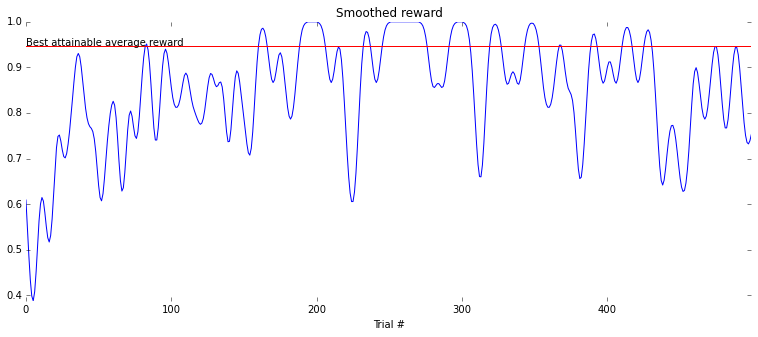

In [98]:
def simulate_binomial_bandit(true_parameters, 
                             knobs,
                             prior_mean,
                             prior_precision,
                             batch_size, 
                             N_batches):
    """ Run the binomial contextual bandit with Thompson sampling policy.
    """
    rewards = np.zeros((N_batches,batch_size))
    for i in range(N_batches):
        # Get a design matrix for this batch
        _, X = thompson_sampling(knobs, prior_mean, prior_precision, batch_size)
        
        # Simulate rewards
        reward_rate = logistic(X.dot(true_parameters))
        batch_rewards = np.random.binomial(1, reward_rate)
        
        # Update the matrix.
        prior_mean, prior_precision = estimate_glm_params(X, 
                                                          batch_rewards, 
                                                          prior_mean, 
                                                          prior_precision)
        
        # Store the outcome.
        rewards[i, :] = batch_rewards
        
    return rewards, prior_mean

def logit(p):
    return np.log(p / (1 - p))

baseline_rate = .5
beta = logit(baseline_rate)
beta_sd = .2

N_knobs = 10
knob_sd = .5

batch_size = 10
N_batches = 50

prior_mean = np.hstack((beta, np.zeros(N_knobs)))
prior_precision = np.diag(np.hstack((1 / beta_sd**2,
                                     np.ones(N_knobs) / knob_sd**2)))

# Pick the parameters from the prior distribution.
true_parameters = sample_normal_mean_precision(prior_mean, prior_precision).squeeze()

knobs = [FixedKnob()]
for i in range(N_knobs):
    knobs.append(CategoricalKnob())

rewards, _ = simulate_binomial_bandit(true_parameters,
                                      knobs,
                                      prior_mean,
                                      prior_precision,
                                      batch_size,
                                      N_batches)

reward_sequence = rewards.ravel()
plt.figure(figsize=(13, 5))

# And also plot a smoother version
sigma = 3
rg = np.arange(-int(3*sigma), int(3*sigma) + 1)
thefilt = np.exp(-(rg**2) / 2 / sigma**2)
thefilt = thefilt / thefilt.sum()
smoothed_sequence = scipy.signal.convolve(reward_sequence, thefilt, 'same')
smoothed_sequence /= scipy.signal.convolve(np.ones_like(reward_sequence), thefilt, 'same')
plt.plot(smoothed_sequence)
plt.axis('tight')
plt.box('off')

# And show the optimal average reward
_, opt_design = sample_optimize_knobs(knobs, true_parameters, prior_precision*10000, 1)
opt_reward = logistic(opt_design.dot(true_parameters))
plt.plot([0, N_batches*batch_size], [opt_reward, opt_reward], 'r-')
plt.text(0, opt_reward, 'Best attainable average reward')
plt.xlabel('Trial #')
plt.title('Smoothed reward')

We see that the contextual bandit with Thompson sampling converges to the optimal policy quite rapidly - in a few hundred trials. Not a bad feat for such a simple method!

# Where's the context?

Our formulation of the contextual bandit was appropriate for optimizing discrete knobs which were entirely under our control. It's less obvious how to apply this method to problems where:

  1. Variables are numerous, continuous and have nonlinear relationships with the reward.
  2. There are variables we observe, in addition to variables we can change.
  
The first problem can be tackled by replacing GLMs with Bayesian neural nets or Gaussian processes - we'll leave that for another day. The second problem is, however, quite tractable.

Consider the medical treatment example. Let's say that we have two variables we care about - sex and age - and we want to optimize under which arm (control or experiment) each new enrolled patient is put. Let's write a generative model for the mean treatment effect:

Then we might have a model where the probability of being healthy at the end of the treatment period is given by:

$$\mu = \text{logistic}(\kappa \cdot (\mathbf{z}^T \mathbf{v} + \beta) + \alpha)$$

Here:

  > $\kappa$: +1 if in the treatment arm, 0 in the control arm
  >
  > $\mathbf{z}$: a vector of measurements from a patient, in this case a 2-element vector containing age and sex (variables centered around 0 for ease of interpretation).
  >
  > $\alpha$: logit of the baseline reward - i.e. the spontaneous recovery rate
  >
  > $\beta$: logit of the incremental reward for treatment, unconditioned on covariates - i.e. how much giving the pill helps for the average person.
  
Now we collect $\mathbf{v}$, $\beta$, $\alpha$ into a vector $\mathbf{w}$, and $\kappa \mathbf{z}$, $\kappa$, 1 into a vector $\mathbf{x}$. Then we can apply the contextual bandit just like we did previously; we simply have to implement a new FactorizedKnob class and modify our simulation framework to sample from sex and age whenever a new patient is encountered. We leave this as an exercise to reader. 